# Описание задания:

## 1) Создать численную модель расчёта компьютерной (синтезированной) голограммы плоского объекта:
а) создаёте исходный объект:

а1) берете любое изображение не очень большого размера (например, 64*64 пикселей) - это амплитуда (матрица значений амплитуды объекта;

а2) создаете фазу объекта - случайное значение от 0 до 2пи;

а3) помещаете поле в угол чёрного объектного поля бОльшего размера (например, N* N=256*256 пикселей);

б) распространяете излучение от плоскости объекта до плоскости голограммы (прямой расчёт дифракции Френеля с использованием одного быстрого преобразования Фурье); длина волны излучения = lamb=532 нм; пиксель голограммы (модельной цифровой камеры)=Pix=5,5 мкм; расстояние от объекта до голограммы = 6 * Z0=6*(N * Pix * Pix / lamb) ;

в) добавляете плоскую опорную волну;

г) находите интенсивность полученной волны (квадрат модуля суммы опорной и объектной волн);

д) квантование голограммы на 256 уровней яркости.
Полученный массив - это синтезированная (компьютерная) голограмма.

Для проверки можно численно восстановить изображение с голограммы с помощью расчёта распространения излучения от плоскости голограммы до объекта (также формула прямого расчёта дифракции Френеля с использованием одного быстрого преобразования Фурье).

Отличие формул расчёта распространения излучения для синтеза и восстановления - это то, что размер пикселя разный. При синтезе пиксель голограммы - это пиксель получаемого массива, а при восстановлении - это пиксель исходного массива. Пиксели исходного и получаемого массивов для обоих вариантов связаны через дифракционную расходимость.

Прикладываю статью, в которой подробнее описан каждый из шагов (разделы 1.1-1.2) (т.к. восстановление с амплитудной голограммы напрямую, то и аналог разделов 1.3-1.4 для амплитудного типа модулятора света).

 
## 2) Сгенерировать набор (датасет) синтезированных голограмм QR-кодов для дальнейшего обучения нейросети.

 
## 3) Используя архитектуру U-net
https://arxiv.org/abs/1505.04597
обучить сеть восстановлению QR-кодов из голограмм. Мы обычно используем Tensorflow
https://www.tensorflow.org/

 
## 4) Протестировать сеть на голограммах QR-кодов, не участвовавших в обучении

In [21]:
%matplotlib inline
import os
os.chdir("..\\images")

C:\Users\user\AppData\Local\Temp\ipykernel_18508\2028628233.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  object_field[0:64, 0:64] = amplitude * np.exp(1j * phase)


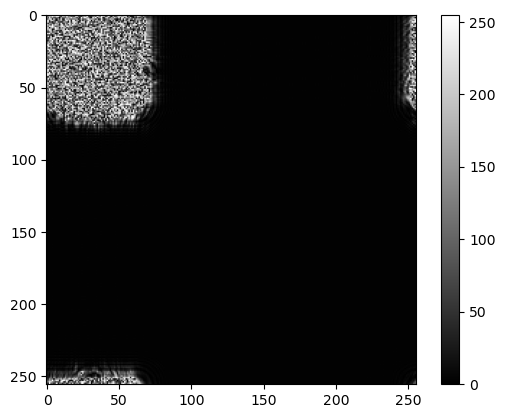

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2, fftshift
from PIL import Image

image = Image.open('shamanking6464.jpg').convert('L')
image.show(title = "leo")
amplitude = np.array(image)
# Создание исходного объекта
#amplitude = np.random.rand(64, 64)  # Матрица значений амплитуды объекта
phase = np.random.uniform(0, np.pi/10, (64, 64))  # Матрица фазы объекта

# Создание поля объектного поля
N = 256
object_field = np.ones((N, N))
object_field[0:64, 0:64] = amplitude * np.exp(1j * phase)

# Расчет дифракции Френеля
wavelength = 532e-9  # Длина волны излучения
pixel_size = 5.5e-6  # Размер пикселя голограммы (модельной цифровой камеры)
def FrenelDifr(object_field, pixel_size = 5.5e-6):
    N = len(object_field)
    distance = 6 * (N * pixel_size * pixel_size / wavelength)  # Расстояние от объекта до голограммы
    x1 = np.linspace(0, N*pixel_size, N)
    y1 = np.linspace(0, N*pixel_size, N)
    x, y = np.meshgrid(x1, y1)
    object_field_fft = fft2(object_field*np.exp(1j * np.pi/(wavelength * distance)*(x**2 + y**2)))
    
    kr = 2 * np.pi / wavelength
    kx = np.fft.fftfreq(N, pixel_size)
    ky = np.fft.fftfreq(N, pixel_size)
    kx, ky = np.meshgrid(kx, ky)
    kz = np.sqrt(kr ** 2 - kx ** 2 - ky ** 2)
    hologram_field_fft = object_field_fft * np.exp(1j * kz * distance) #Распространение волнового фронта на z
    hologram_field = ifft2(hologram_field_fft)
    return hologram_field
hologram_field = FrenelDifr(object_field)
# Добавление плоской опорной волны
reference_wave = np.ones((N, N), dtype=complex)
hologram_field += reference_wave

# Расчет интенсивности полученной волны
intensity = np.uint8(np.abs(hologram_field) ** 2)

# Визуализация результата
plt.imshow(intensity, cmap='gray')
plt.colorbar()
plt.show()

In [6]:
import os
os.getcwd()

'd:\\JupiterFolder\\Holography\\images'

In [16]:
signal = np.array([-2, 8, 6, 4, 1, 0, 3, 5,1,0], dtype=float)
fourier = np.fft.fft(signal)
n = signal.size
timestep = 0.1
freq = np.fft.fftfreq(n, d=timestep)
freq

array([ 0.,  1.,  2.,  3.,  4., -5., -4., -3., -2., -1.])

In [20]:
intensity.shape

(256, 256)

<AxesSubplot:>

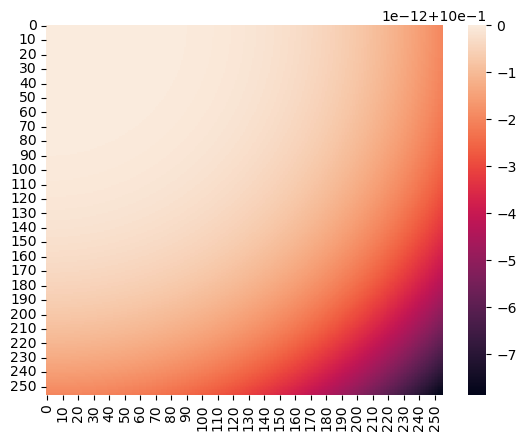

In [84]:
x1 = np.linspace(0, 256*pixel_size, 256)
y1 = np.linspace(0, 256*pixel_size, 256)
x, y = np.meshgrid(x1,y1)
(x*y).shape
import seaborn as sns
sns.heatmap(np.cos(x**2+y**2))